# Implement Inner Product Fits in LAL
<center> Using LAL to directly calculate inner-products is too expensive. So let's implement fome fits for this. </center>

#### Notes:
 * Inner Product fits have been implemented in LAL. 
 * The fits are rational polynomials of the mapped spin parameter
 * NOTE that the oscillations in the residuals are a physical feature that is typically imperceptible when looking at QNM related quantities

## Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
#
# from os import system
# system('source ~/.virtual_enviroments/ringdownFD_nikhef/bin/activate')
from nrutils.core.basics import lalphenom
from kerr import rgb,gmvpfit,modelrd,anglep,qnmfit,leaver,ndflatten,sunwrap,alert,cyan,slm,ysprod,ssprod
from kerr.models import mmrdns as ns
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
import corner
#
from numpy import *
from numpy.linalg import pinv
#
from nrutils.core.units import *
#
from scipy.optimize import minimize
from os.path import expanduser
#
import lal
from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
import lalsimulation as lalsim
alert('The LASIMULATION version is located at: %s'%( bold(yellow(lalsim.__path__[0])) ))
#
import review_ringdownFD_nikhef as review
from nrutils.analyze.match import match as match_object
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
plotdir = '/Users/book/KOALA/review_ringdownFD_nikhef/gallery/'

(<module>)>> The LASIMULATION version is located at: /Users/book/.virtual_enviroments/ringdownFD_nikhef/opt/lalsuite/lib/python2.7/site-packages/lalsimulation


## Spot check LAL function vs Python

In [2]:
jf = 0.5
ll,mm = 2,2
l,m,n = 2,mm,0
print lalsim.QNM_YSPROD(jf,ll,mm,l,m,n), ysprod(jf,ll,mm,(l,m,n))

(0.99898412545-0.00649893229554j) (0.998984039154-0.00649989023823j)


## Plot comparison on BH spin (single case)

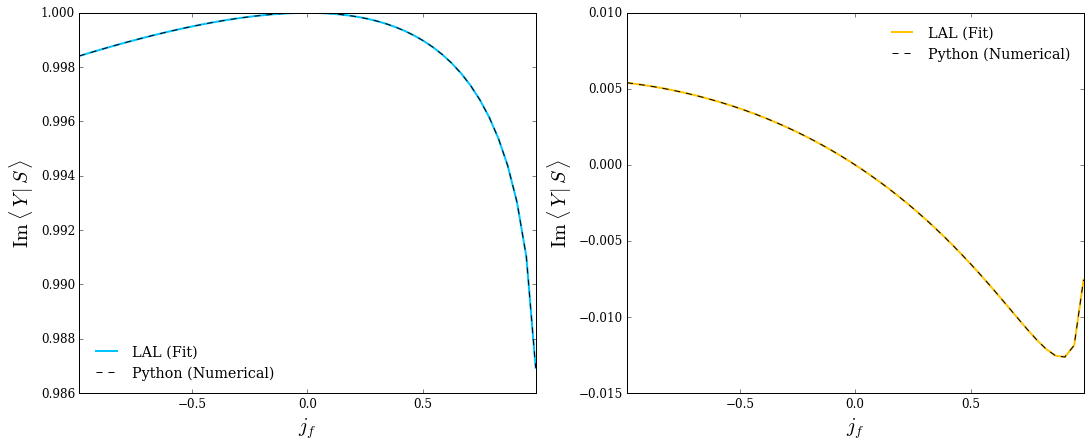

In [3]:
jfrange = 0.99*linspace(-1,1)
yslal = array( [ lalsim.QNM_YSPROD(j,ll,mm,l,m,n) for j in jfrange ] )
yspy = array( [ ysprod(j,ll,mm,(l,m,n)) for j in jfrange ] )

fig = figure( figsize=3*array([6,5]) )
clr = rgb(2)

subplot(2,2,1)
plot( jfrange, yslal.real, linewidth=2, color=clr[0], label='LAL (Fit)' )
plot( jfrange, yspy.real, linewidth=1, color='k', linestyle='--', label='Python (Numerical)' )
legend(frameon=False,loc='best')
xlabel(r'$j_f$'); ylabel(r'$\mathrm{Im}\;\langle \, Y \,| \, S \, \rangle$')
xlim( lim(jfrange) )

subplot(2,2,2)
plot( jfrange, yslal.imag, linewidth=2, color=clr[-1], label='LAL (Fit)' )
plot( jfrange, yspy.imag, linewidth=1, color='k', linestyle='--', label='Python (Numerical)' )
legend(frameon=False,loc='best')
xlabel(r'$j_f$'); ylabel(r'$\mathrm{Im}\;\langle \, Y \,| \, S \, \rangle$')
xlim( lim(jfrange) )

# Save figure
figpath = plotdir+'issue_2b_ImplementInnerProductFits_LMlmn22220.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

## Plot many cases

(plotyscomparison)>> Working [2, 2, 2, 2, 0] ...
(plotyscomparison)>> Working [2, 2, 2, 2, 1] ...
(plotyscomparison)>> Working [2, 1, 2, 1, 0] ...
(plotyscomparison)>> Working [3, 3, 3, 3, 0] ...
(plotyscomparison)>> Working [3, 3, 3, 3, 1] ...
(plotyscomparison)>> Working [3, 2, 3, 2, 0] ...
(plotyscomparison)>> Working [3, 2, 2, 2, 0] ...
(plotyscomparison)>> Working [3, 2, 2, 2, 1] ...
(plotyscomparison)>> Working [4, 4, 4, 4, 0] ...
(plotyscomparison)>> Working [4, 3, 4, 3, 0] ...
(plotyscomparison)>> Working [4, 3, 3, 3, 0] ...
(plotyscomparison)>> Working [5, 5, 5, 5, 0] ...


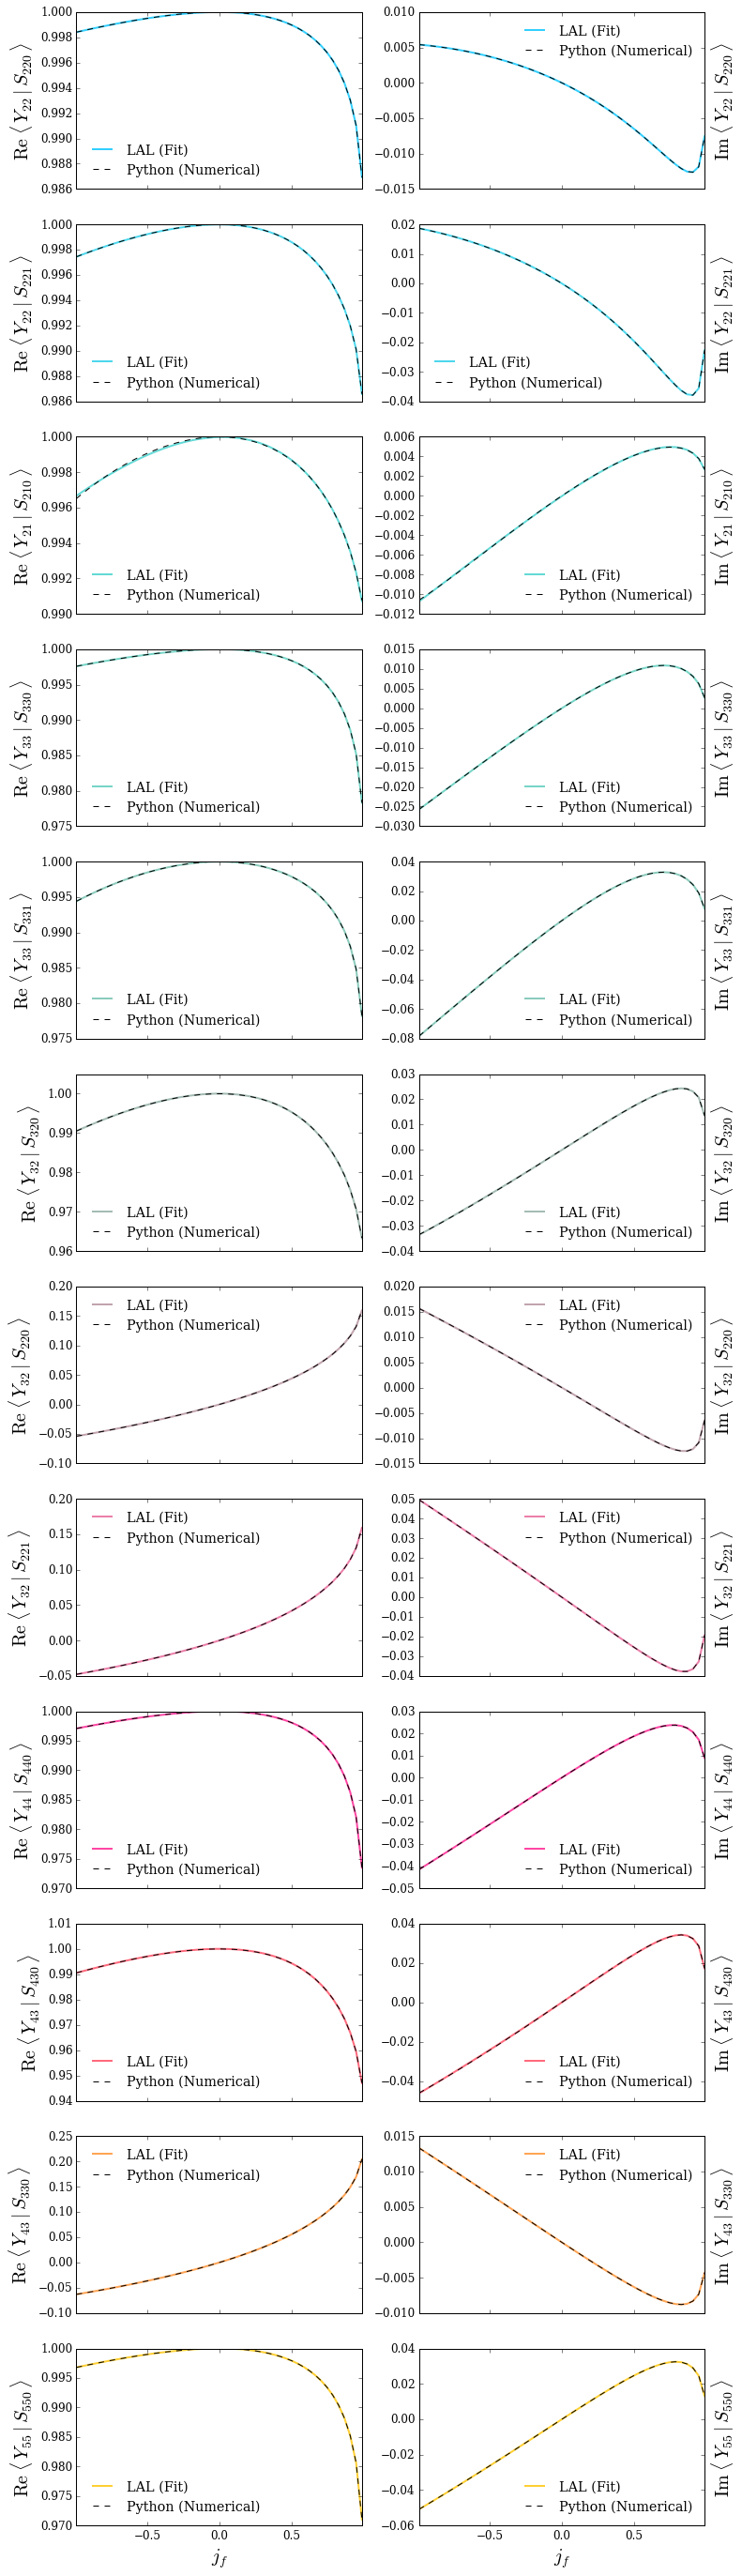

In [23]:
jfrange = 0.99*linspace(-1,1)

# jk = [ (2,2,2,2,0), (5,5,5,5,0) ]
jk = [ (2,2,2,2,0), (2,2,2,2,1), (2,1,2,1,0), (3,3,3,3,0), (3,3,3,3,1), (3,2,3,2,0), (3,2,2,2,0), (3,2,2,2,1), (4,4,4,4,0), (4,3,4,3,0), (4,3,3,3,0), (5,5,5,5,0) ]
h = len(jk)
fig,ax = subplots(h,2,sharex=True,figsize=4*array([3,h]))
ax = ax.flatten(); clr = rgb(h)

def plotyscomparison(ll,mm,l,m,n,k):

    yslal = array( [ lalsim.QNM_YSPROD(j,ll,mm,l,m,n) for j in jfrange ] )
    yspy = array( [ ysprod(j,ll,mm,(l,m,n)) for j in jfrange ] )

    j = 2*k
    alert('Working %s ...'%(str([ll,mm,l,m,n])))
    
    sca(ax[j])
    plot( jfrange, yslal.real, linewidth=2, color=clr[k], label='LAL (Fit)', alpha=0.8 )
    plot( jfrange, yspy.real, linewidth=1, color='k', linestyle='--', label='Python (Numerical)' )
    legend(frameon=False,loc='best')
    if k == h-1 : xlabel(r'$j_f$')
    ylabel(r'$\mathrm{Re}\;\langle \, Y_{%i%i} \,| \, S_{%i%i%i} \, \rangle$'%(ll,mm,l,m,n))
    xlim( lim(jfrange) )

    sca(ax[j+1])
    plot( jfrange, yslal.imag, linewidth=2, color=clr[k], label='LAL (Fit)', alpha=0.8 )
    plot( jfrange, yspy.imag, linewidth=1, color='k', linestyle='--', label='Python (Numerical)' )
    legend(frameon=False,loc='best')
    if k == h-1 : xlabel(r'$j_f$')
    ylabel(r'$\mathrm{Im}\;\langle \, Y_{%i%i} \,| \, S_{%i%i%i} \, \rangle$'%(ll,mm,l,m,n))
    xlim( lim(jfrange) )
    ax[j+1].yaxis.set_label_position("right")
    
k = 0
for k,(ll,mm,l,m,n) in enumerate(jk):
    plotyscomparison(ll,mm,l,m,n,k)
    
# Save figure
figpath = plotdir+'issue_3_ImplementInnerProductFits.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )

## Plot Residuals

(plotyscomparison)>> Working [2, 2, 2, 2, 0] ...
(plotyscomparison)>> Working [2, 2, 2, 2, 1] ...
(plotyscomparison)>> Working [2, 1, 2, 1, 0] ...
(plotyscomparison)>> Working [3, 3, 3, 3, 0] ...
(plotyscomparison)>> Working [3, 3, 3, 3, 1] ...
(plotyscomparison)>> Working [3, 2, 3, 2, 0] ...
(plotyscomparison)>> Working [3, 2, 2, 2, 0] ...
(plotyscomparison)>> Working [3, 2, 2, 2, 1] ...
(plotyscomparison)>> Working [4, 4, 4, 4, 0] ...
(plotyscomparison)>> Working [4, 3, 4, 3, 0] ...
(plotyscomparison)>> Working [4, 3, 3, 3, 0] ...
(plotyscomparison)>> Working [5, 5, 5, 5, 0] ...


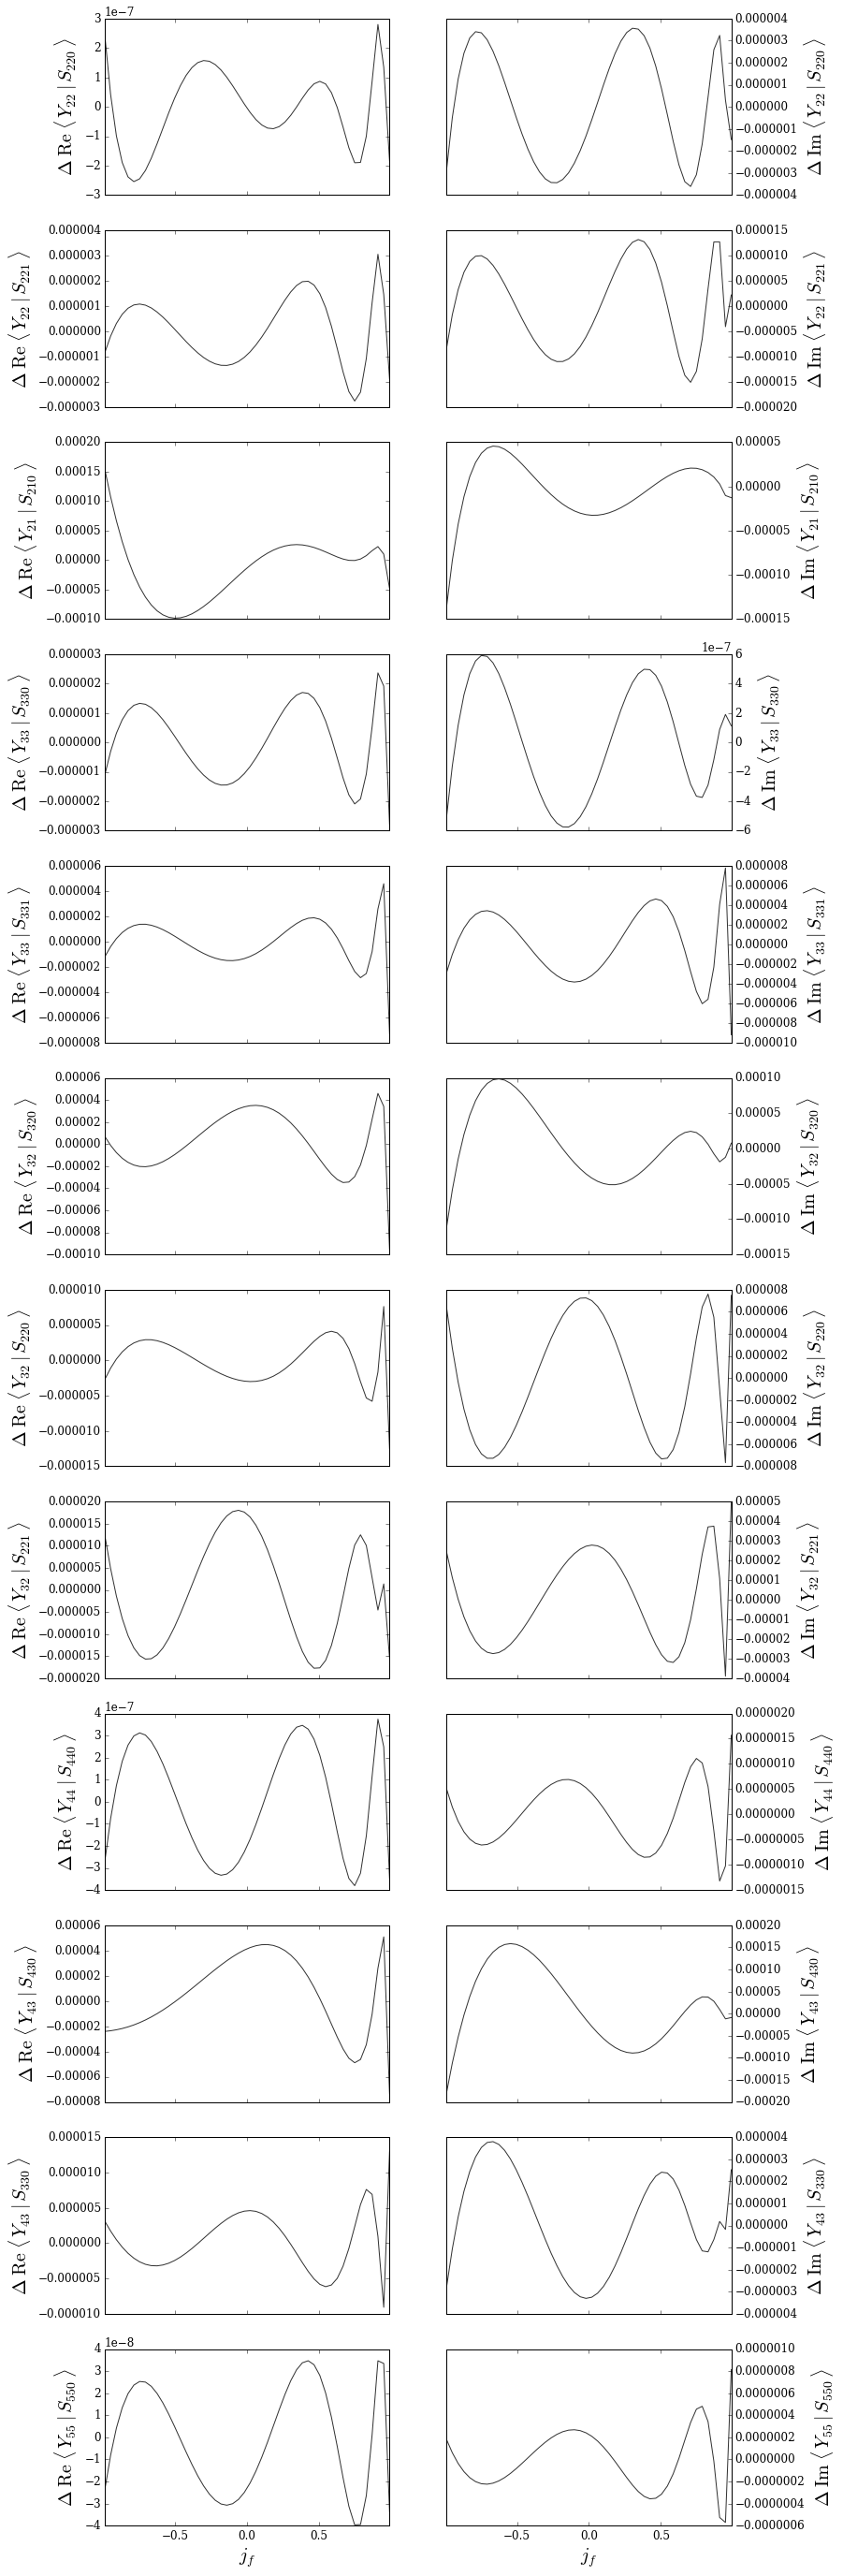

In [29]:
jfrange = 0.99*linspace(-1,1)

# jk = [ (2,2,2,2,0), (5,5,5,5,0) ]
jk = [ (2,2,2,2,0), (2,2,2,2,1), (2,1,2,1,0), (3,3,3,3,0), (3,3,3,3,1), (3,2,3,2,0), (3,2,2,2,0), (3,2,2,2,1), (4,4,4,4,0), (4,3,4,3,0), (4,3,3,3,0), (5,5,5,5,0) ]
h = len(jk)
fig,ax = subplots(h,2,sharex=True,figsize=4*array([3,h]))
ax = ax.flatten(); clr = rgb(h)

def plotyscomparison(ll,mm,l,m,n,k):

    yslal = array( [ lalsim.QNM_YSPROD(j,ll,mm,l,m,n) for j in jfrange ] )
    yspy = array( [ ysprod(j,ll,mm,(l,m,n)) for j in jfrange ] )

    j = 2*k
    alert('Working %s ...'%(str([ll,mm,l,m,n])))
    
    sca(ax[j])
    plot( jfrange, yslal.real-yspy.real, linewidth=1, color=0*clr[k], alpha=0.8 )
    if k == h-1 : xlabel(r'$j_f$')
    ylabel(r'$\Delta \; \mathrm{Re}\;\langle \, Y_{%i%i} \,| \, S_{%i%i%i} \, \rangle$'%(ll,mm,l,m,n))
    xlim( lim(jfrange) )

    sca(ax[j+1])
    plot( jfrange, yslal.imag-yspy.imag, linewidth=1, color=0*clr[k], alpha=0.8 )
    if k == h-1 : xlabel(r'$j_f$')
    ylabel(r'$\Delta \; \mathrm{Im}\;\langle \, Y_{%i%i} \,| \, S_{%i%i%i} \, \rangle$'%(ll,mm,l,m,n))
    xlim( lim(jfrange) )
    ax[j+1].yaxis.set_label_position("right")
    ax[j+1].yaxis.tick_right()
    
k = 0
for k,(ll,mm,l,m,n) in enumerate(jk):
    plotyscomparison(ll,mm,l,m,n,k)
    
# Save figure
figpath = plotdir+'issue_3_ImplementInnerProductFitResiduals.pdf'
savefig( figpath, bbox_inches='tight', pad_inches=0.125 )